<a href="https://colab.research.google.com/github/urieliram/tc_uc/blob/main/Figures_TC_UC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paquetes

In [1]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# Gráficos
# ==============================================================================
from matplotlib import style
import seaborn as sns
cm = 1/2.54

# Modelado y test estadísticos
# ============================================================================
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import ks_2samp
from scipy import stats
from scipy.stats import shapiro
import scipy.stats as stats

# Configuración matplotlib
# ==============================================================================
# Gráficos distribución observada 
# ============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
import seaborn as sns
# plt.style.use('ggplot')

# GRÁFICOS DE CONVERGENCIA milp, milp2, hard3, harjk lbc, ks, 


## Lectura de archivos log

In [2]:
## Lectura de datos
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Log1.zip to Log1.zip
User uploaded file "Log1.zip" with length 1725597 bytes


In [ ]:
!unzip "Log1.zip" -d "/content"
# ó
# !pip install unrar
# !unrar x "/content/Logs1.rar"

## Lectura de archivo de resultados stat.xls

In [4]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
# URL  = 'https://drive.google.com/file/d/1ySF5y3FdEZrEAu1jZ_P1PdBJSk64TQvt/view?usp=share_link'
# df   = pd.read_csv(path+URL.split('/')[-2],header=0)
URL        = 'https://docs.google.com/spreadsheets/d/12byid7r6dwnpYgbWWrvWrYQtlFfsPhI6Meq9tcF-DBU/edit?usp=sharing'
sheet_id   = '12byid7r6dwnpYgbWWrvWrYQtlFfsPhI6Meq9tcF-DBU'
sheet_name = 'stat1'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
df   = pd.read_csv(url,header=0)
# df.dropna(inplace=True)
## x10gen_small 081-090
## x10gen_large 091-100
## x7day_small  061-070
## x7day_large  071-080 , 131-152
## x7day_medium 101-131

filter = 'x7day_small' ## x10gen_small, x10gen_large ,x7day_small, x7day_large, 
df = df[(df['groupx'] == filter)]

!mkdir Figures
dir = '/content/Figures/'

In [5]:
list=[]
nameins   = df.nameins
for i in nameins:
  list.append('Log_'+i.replace('.json', '').replace('uc_', ''))
print(len(list))

20


## Extrae información de los logs y construye gráficas

In [6]:
class ExtractCPLEX:

  def findPos(self,file,spected, starter = "Node  Left"):
    file = open(file,"r")
    for i,j in enumerate(file):
      if starter in j:
        return [(j.index(k)+len(k)-1) for k in spected]
  
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*Logfile\s*\'*[a-zA-z.+]*\'",data):
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp

  def createTables(self,fn):
    table_start = False
    spected = ['Node', 'Left', 'Objective', 'IInf', 'Integer', 'Bound', 'ItCnt', 'Gap']
    expectedPositions = self.findPos(fn,spected)
    tables = {"seconds":[],"ticks":[],"solution":[],"Node":[],"Left":[],"Objective":[],"IInf":[],"Integer":[],"Bound":[],"ItCnt":[],"Gap":[],"cuts":[]}
    time = None
    ticks = None
    cuts = None
    f = open(fn,"r")    
    for i in f:
      if re.findall(r"\d{1,}[+]{1}\d{1,}",i):
        i = " ".join(i.split("+"))
      if("Cover cuts applied" in i or "Performing restart 1" in i):
        table_start = False
      if("Elapsed time" in i):
          tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          time = tmp[0]
          ticks = tmp[1]
      if(table_start):        
        if((str(i)[0] == " " or str(i)[0] == "*") and str(i)[expectedPositions[0]].isdigit()):
          i = i.replace("uts: "," uts:")
          tables["seconds"].append(time)
          tables["ticks"].append(ticks)
          tables["solution"].append(1 if i[0]=="*" else 0)
          tables["cuts"].append(None)
          for j,m in zip(expectedPositions,spected):
            if i[j] != " ":
              tmp = ""
              for k in range(j,0,-1):
                if i[k] != " ":
                  tmp += i[k]
                else: 
                  break 
              tmp = tmp[::-1]
              if("ut" in tmp.lower() or "infeasible" in tmp.lower() or "integral" in tmp.lower()):
                if("uts" in tmp.lower()):
                  tables["cuts"][-1] = int(tmp.split(":")[1])
                tables[m].append(tables[m][-1])
              else:
                if m == "Gap":
                  tables[m].append(float(tmp)/100)
                else: 
                  tables[m].append(float(tmp))
            else:
              tables[m].append(None)
      if("Node  Left"):
        table_start = True
    return tables

  def extract(self,fn):
    variables = {"mipPresolveEliminated":[],"mipPresolveModified":[],"aggregatorDid":[],"reducedMipHasColumns":[],"reducedMipHasNonZero":[],"reducedMipHasBinaries":[],"reducedMipHasGeneral":[],"cliqueTableMembers":[],"rootRelaxSolSeconds":[],"rootRelaxSolTicks":[]}
    variables["logFile"] = self.getFilelog(fn)
    tables = self.createTables(fn)
    f = open(fn, "r")    
    for i in f:
      if("linear optimization" in i):
        variables["linearOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("optimality gap tolerance" in i):
        variables["gapTol"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("time limit in seconds" in i):
        variables["timeLimit"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("emphasis for MIP optimization" in i):
        variables["mipOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Objective sense" in i):
        variables["objSense"] = i.replace(" ","").replace("\n","").split(":")[1]
      if("Variables" in i):
        if("Box:" in i):
          variablesValue = ["variablesValue","Nneg","Box","Binary"]
          for j,k in enumerate(re.findall(r'\d+', i.replace(" ","").replace("\n","").split(":",1)[1])):
            variables[variablesValue[j]] = float(k)
        else:
          variablesValue = ["minLB","maxUb"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
      if("Objective nonzeros" in i):
        if("Min" in i or "Max" in i):
          variablesValue = ["objNonZerosMin","objNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["objNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Linear constraints" in i):
        if("Less" in i):
          variablesValue = ["linearConstraintsValue","less","greater","equal"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          pass
      if("Nonzeros" in i):
        if("Min" in i):
          variablesValue = ["nonZerosMin","nonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["nonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("RHS nonzeros" in i):
        if("Min" in i):
          variablesValue = ["rhsNonZerosMin","rhsNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["rhsNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("CPXPARAM_TimeLimit" in i):
        variables["CPXPARAM_TimeLimit"] = float(i.replace("\n","").split(" ")[-1])
      if("MIP Presolve eliminated" in i):
        variables["mipPresolveEliminated"].append([int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)])
      if("MIP Presolve modified " in i):
        variables["mipPresolveModified"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Reduced MIP has" in i):
        if("indicators." in i):
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasBinaries"].append(tmp[0])
          variables["reducedMipHasGeneral"].append(tmp[1])
        else:
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasColumns"].append(tmp[1])
          variables["reducedMipHasNonZero"].append(tmp[-1])
          reduceHasGeneral = []
      if("Clique" in i):
        variables["cliqueTableMembers"].append(float(i.replace(" ","").replace("\n","").split(":")[1]))
      if("Aggregator did" in i):
        variables["aggregatorDid"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Root relaxation" in i):
        tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
        variables["rootRelaxSolSeconds"].append(tmp[0])
        variables["rootRelaxSolTicks"].append(tmp[1])
      if("Lift and" in i):
        variables["liftAndProjectCuts"] = int(i.replace(" ","").replace("\n","").split(":")[1])
      if("Gomory fractional" in i):
        variables["gomoryFract"] = int(i.replace(" ","").replace("\n","").split(":")[1])

    df=pd.DataFrame.from_dict(tables).rename(columns={"seconds":"seconds","ticks":"ticks","solution":"solution","Node":"node","Left":"nodesLeft","Objective":"objective","IInf":"iinf","Integer":"bestInteger","Bound":"BestBound","ItCnt":"itCnt","Gap":"gap","cuts":"cuts"})
    ## Ajuste de lectura de datos del log CPLEX
    df = df[ df['bestInteger'] > 10 ]

    df['seconds'] = df['seconds'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    # df['eps'] = eps
    # sum_column = df["seconds"] + df["eps"]
    # df["seconds"] = sum_column
    # df['ticks'] = df['ticks'].fillna(0)
    # eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    # df['eps'] = eps
    # sum_column = df["ticks"] + df["eps"]
    # df["ticks"] = sum_column
    return df,variables

## Test ExtractCPLEX
# e = ExtractCPLEX()
# dfe, dic = e.extract("/content/logfileMilpuc_022.log")
# print(dfe)
# dfe.plot.line( x='seconds',y='bestInteger',style='o-',label='_nolegend_')


In [7]:
class Extract:
  def __init__(self,log):
    self.log = log 
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*"+self.log+"\s*\'*[a-zA-z.+]*\'",data):
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp
  def extract(self):
    fn= "/content/"+self.log+".log"
    variables = {}
    variables["logFile"] = self.log.replace("Log","uc")
    f = open(fn, "r")
    for i in f:

      variables["flag_milp"] = False
      try:
        if("z_milp=" in i):
          variables["z_milp"    ] = float(i.replace(" ","").replace("\n","").split("=")[1])
          variables["flag_milp" ] = True
      except:
        print('!!!Error en z_milp')
        variables["z_milp"   ] = 1E+75
        variables["flag_milp"] = True
      try:
        if("t_milp=" in i):
          variables["t_milp"]  = float(i.replace(" ","").replace("\n","").split("=")[1])
      except:
        print('!!!Error en t_milp')

    start = ["lbc1 results","lbc2 results","lbc3 results","lbc4 results","KS results"]
    stop  = ["lbc1 end"    ,"lbc2 end"    ,"lbc3 end"    ,"lbc4 end"    ,"KS end"    ]
    for p in range(5):
      pattern_start = re.compile(r""+start[p])
      pattern_stop  = re.compile(r""+"^"+stop[p])
      i = 0
      extract_on = False
      extracts = []
      with open(r''+fn, 'rt') as myfile:
          for line in myfile:
              i += 1  # line counting starts with 1
              if pattern_start.match(line):
                  extract_on = True
              if pattern_stop.search(line):
                  extract_on = False
              if extract_on:
                  extracts.append((i, line.rstrip('\n')))
      listlines=[]; x=[]; y=[]
      for line in extracts:
        listlines.append(line[1])
      if len(listlines)!=0:
        del listlines[0]
      for i in listlines:
        if float(re.split(',',i.replace(" ",""))[1])!=1E+75:
          x.append(float(re.split(',',i.replace(" ",""))[0]))
          y.append(float(re.split(',',i.replace(" ",""))[1]))
      if p==0:
        variables["t_lbc1"] = x
        variables["z_lbc1"] = y
        variables["flag_lbc1"] = True
      if p==1:
        variables["t_lbc2"] = x
        variables["z_lbc2"] = y
        variables["flag_lbc2"] = True
      if p==2:
        variables["t_lbc3"] = x
        variables["z_lbc3"] = y
        variables["flag_lbc3"] = True
      if p==3:
        variables["t_lbc4"] = x
        variables["z_lbc4"] = y
        variables["flag_lbc4"] = True
      if p==4:
        variables["t_KS"] = x
        variables["z_KS"] = y
        variables["flag_KS"] = True
    return variables

if False:
  ex         = Extract('Log_112')
  variablesx = ex.extract()
  print(variablesx)

In [8]:
def graficas(title='',graphs=[]):
  df1      = df[df['nameins'] == title+'.json' ]
  timefull = int(df1.timefull)
  plt.figure()
  mpl.rcParams['font.size'] = 12
  ## Estandarizamos eje 'y'
  ax = plt.gca()
  ax.get_yaxis().get_major_formatter().set_useOffset(False)

  models = ['LB1','LB2','LB3','LB4','KS','MILP']
  i = 0
  group_=''
  for tup in graphs:
      x = tup[0]
      y = tup[1]
  ##  Recortamos a timefull
      x1=[]
      y1=[]
      index = 0
      for j in x:
        if j < timefull:
          x1.append(j)
          y1.append(y[index])
        else:
          x1.append(timefull)
          y1.append(y[index])
          break
        index = index + 1
      if tup[2]:
        plt.plot(x1, y1, '.-', label = models[i],markersize=8,)
      i=i+1

  ##  Extraemos Milp2
  # if False:
  #   e        = ExtractCPLEX()
  #   df3, dic = e.extract("/content/logfileMilp2"+title+".log")  
  #   x        = df3['seconds'].values.tolist()
  #   y        = df3['bestInteger'].values.tolist()
  #   xr       = np.array(x)
  #   t_harduc = int(df1.t_harduc)
  #   xr       = xr + t_harduc           ##  Agregamos los segundos de Harduc
  #   groupx   = str(df1.groupx.iloc[0])
  #   x1=[]  
  #   y1=[]
  #   index = 0
  #   for j in xr:                       ##  Recortamos MILP2 a timefull
  #     if j < timefull:
  #       x1.append(j)
  #       y1.append(y[index])
  #     else:
  #       x1.append(timefull)
  #       y1.append(y[index])
  #       break
  #     index = index + 1
  # plt.plot(x1,y1,'x',Label = models[6],color='magenta')

  ##  Extraemos Milp
  try:
    e        = ExtractCPLEX()
    df4, dic = e.extract("/content/logfileMilp"+title+".log")
    x        = df4['seconds'    ].values.tolist()
    y        = df4['bestInteger'].values.tolist()
    plt.plot(x,y,'x',Label = 'MILP',color='#ff6666')
  except:
    print('!!!Error en MILP '+title)

  plt.xlabel("Time (seconds)")
  plt.ylabel("z ($)")
  plt.title('Instance '+title+'\n ('+filter+')') ###########################################################################
  plt.legend(bbox_to_anchor=(1, 0.75))


  if title == 'uc_122':
    plt.ylim([8.13550E+7,8.139E+7])
  if title == 'uc_124':
    plt.ylim([8.0347E+7,8.037E+7])

  if title == 'uc_062':
    plt.ylim([3.2365E+7,3.24E+7])
  if title == 'uc_069':
    plt.ylim([3.287E+7,3.291E+7])
  if title == 'uc_101':
    plt.ylim([3.84E+7,3.848E+7])
  if title == 'uc_103':
    plt.ylim([4.234E+7,4.236E+7])

  if title == 'uc_075':
    plt.ylim([1.1214E+8,1.1217E+8])
  if title == 'uc_077':
    plt.ylim([1.27066E+8,1.271E+8])
  if title == 'uc_147':
    plt.ylim([1.5104E+8,1.5108E+8])
  if title == 'uc_149':
    plt.ylim([1.5661E+8,1.56641E+8])
  if title == 'uc_151':
    plt.ylim([1.5574E+8,1.55775E+8])

  # timefull = int(df1.timefull)
  # timeconst= int(df1.timeconst)
  # plt.xlim([timeconst, timefull])
  plt.tight_layout()
  plt.savefig(dir+'fig:'+title+'_'+filter+'.pdf')
  # plt.show()
  return x, y

## Gráficos de convergencia 

In [9]:
fontsize=14
palette=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#ff6666','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
# tab:blue,tab:orange,tab:green,tab:red,tab:purple,coral,tab:brown,tab:pink,tab:gray,tab:olive,tab:cyan

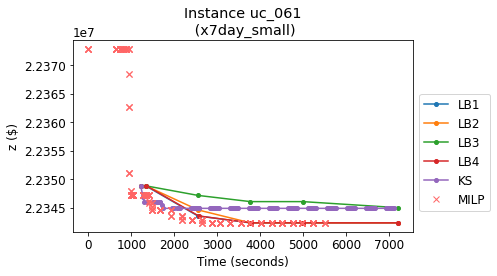

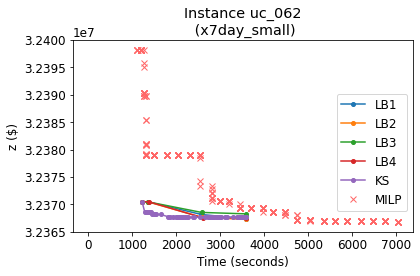

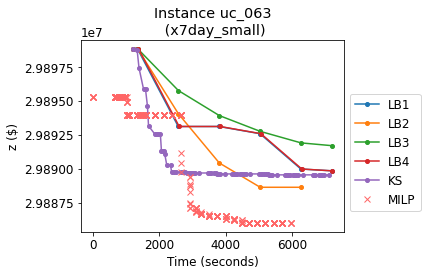

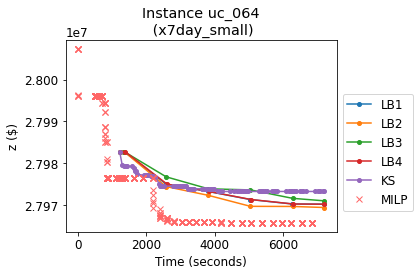

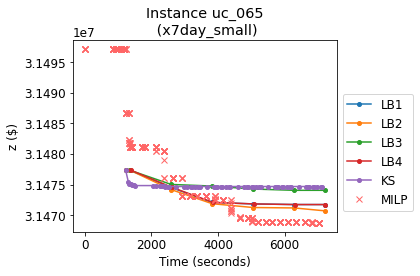

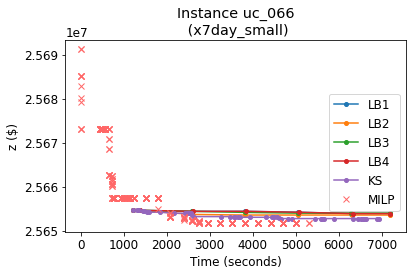

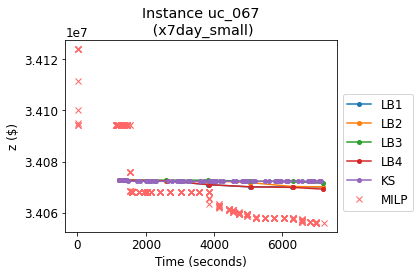

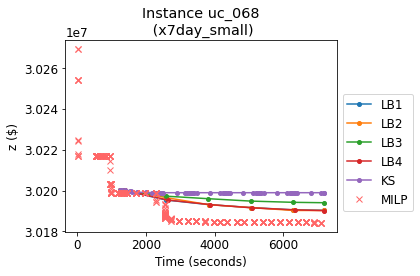

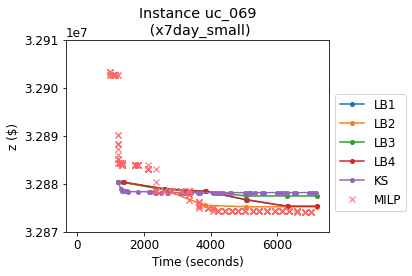

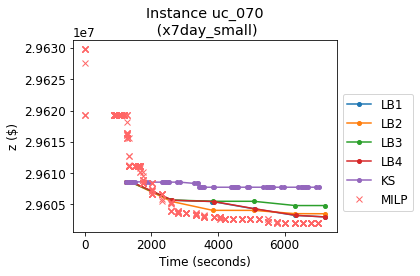

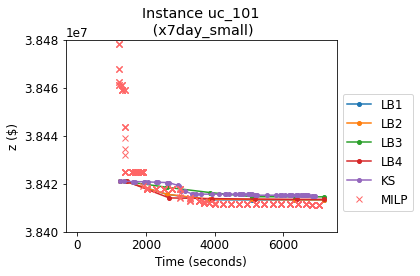

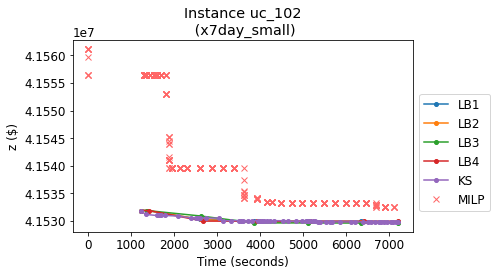

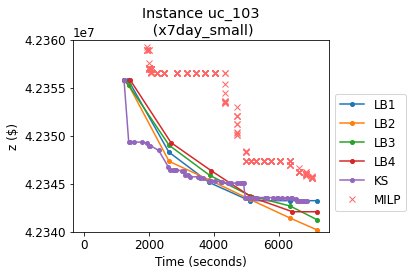

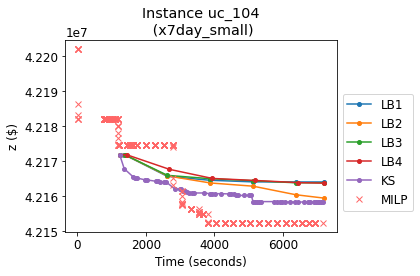

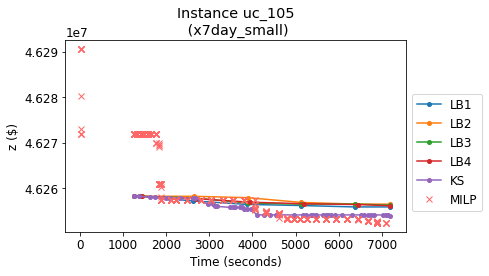

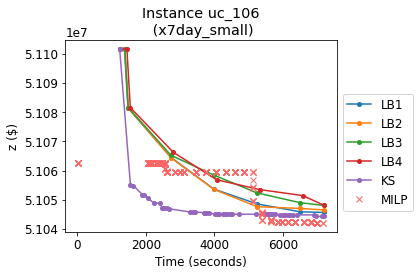

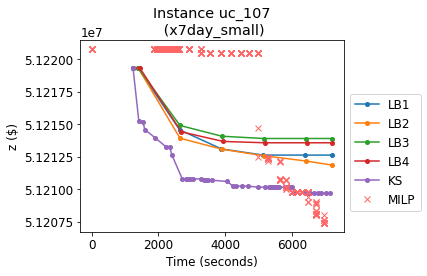

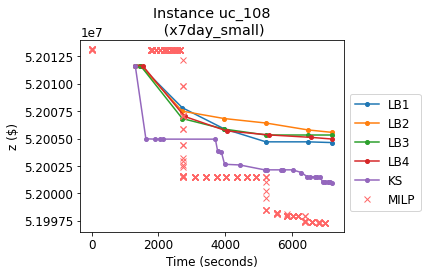

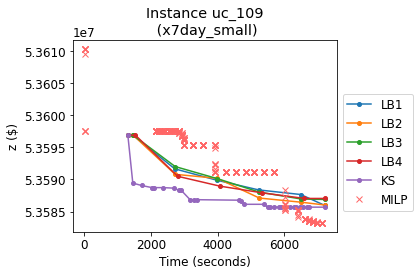

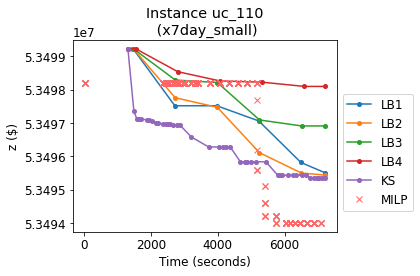

In [10]:
res=[] ## Vector de resultados de todos los métodos
for item in list:
    graphs = []
    try:
      e = Extract(item)
      variables = e.extract()
      if True:
        #variables["flag_harjk"] = False
        # variables["flag_KS"   ] = False
        # variables["flag_lbc1" ] = False
        # variables["flag_lbc2" ] = False
        # variables["flag_lbc3" ] = False
        # variables["flag_lbc4" ] = False
        # graphs.append(([variables['t_harjk']],[variables['z_harjk']],variables["flag_harjk"]))
        # graphs.append(([variables['t_milp2']],[variables['z_milp2']],variables["flag_milp2"]))       
        # graphs.append(([variables['t_hard3']],[variables['z_hard3']],variables["flag_hard3"])) 
        # graphs.append(([variables['t_milp' ]],[variables['z_milp' ]],variables["flag_milp" ]))
        graphs.append(( variables['t_lbc1' ] , variables['z_lbc1'  ] , variables["flag_lbc1" ]))
        graphs.append(( variables['t_lbc2' ] , variables['z_lbc2'  ] , variables["flag_lbc2" ]))
        graphs.append(( variables['t_lbc3' ] , variables['z_lbc3'  ] , variables["flag_lbc3" ]))
        graphs.append(( variables['t_lbc4' ] , variables['z_lbc4'  ] , variables["flag_lbc4" ]))
        graphs.append(( variables['t_KS'   ] , variables['z_KS'    ] , variables["flag_KS"   ]))
        ## Función que grafica e incluye MILP
        a,b = graficas(title=variables["logFile"],graphs=graphs)
        graphs.append((a,b,True))
        res.append(graphs)
    except Exception as err:
      print("Fail in ", item+".log"+ " file")
      print(str(err))

## Estudio a una hora

In [11]:
def gap(bestbound,bestinteger):
  return abs(bestbound-bestinteger)/(1e-10+abs(bestinteger)) ## https://www.ibm.com/docs/pl/icos/12.9.0?topic=parameters-relative-mip-gap-tolerance

In [12]:
len(df.lb_milp)

20

In [13]:
lb_milp = pd.to_numeric(df.lb_milp).to_numpy() ## LOWER BOUND MILP
lbc1_1h=[]; lbc2_1h=[]; lbc3_1h=[]; lbc4_1h=[]; ks_1h=[]; milp_1h=[]
seconds = 4000
k       = 0 
valor   = 0
for item in res:  
  i=0     ## lbc1_1h
  for x in item[0][0]:
    if x>seconds:
      break
    valor = item[0][1][i]
    i=i+1
  lbc1_1h.append(gap(lb_milp[k],valor))
 
  valor=0  ## lbc2_1h
  i=0   
  for x in item[1][0]:
    if x>seconds: 
      break
    valor = item[1][1][i]
    i=i+1
  lbc2_1h.append(gap(lb_milp[k],valor))
 
  valor=0  ## lbc3_1h
  i=0   
  for x in item[2][0]:
    if x>seconds: 
      break
    valor = item[2][1][i]
    i=i+1
  lbc3_1h.append(gap(lb_milp[k],valor))
 
  valor=0  ## lbc4_1h
  i=0   
  for x in item[3][0]:
    if x>seconds: 
      break
    valor = item[3][1][i]
    i=i+1
  lbc4_1h.append(gap(lb_milp[k],valor))
 
  valor=0  ## ks_1h  
  i=0   
  for x in item[4][0]:
    if x>seconds: 
      break
    valor = item[4][1][i]
    i=i+1
  ks_1h.append(gap(lb_milp[k],valor))

  valor=0  ## milp_1h
  i=0   
  for x in item[5][0]:
    if x>seconds: 
      break
    valor = item[5][1][i]
    i=i+1
  milp_1h.append(gap(lb_milp[k],valor))
  k=k+1

In [14]:
lbc1_1h  = np.asarray(lbc1_1h)
lbc2_1h  = np.asarray(lbc2_1h)
lbc3_1h  = np.asarray(lbc3_1h)
lbc4_1h  = np.asarray(lbc4_1h)
ks_1h    = np.asarray(ks_1h)
milp_1h  = np.asarray(milp_1h)
lbc1_1h  = lbc1_1h[~np.isnan(lbc1_1h)] ## limpiamos NaN
lbc2_1h  = lbc2_1h[~np.isnan(lbc2_1h)]
lbc3_1h  = lbc3_1h[~np.isnan(lbc3_1h)]
lbc4_1h  = lbc4_1h[~np.isnan(lbc4_1h)]
ks_1h    = ks_1h[  ~np.isnan(ks_1h  )]
milp_1h  = milp_1h[~np.isnan(milp_1h)]                 

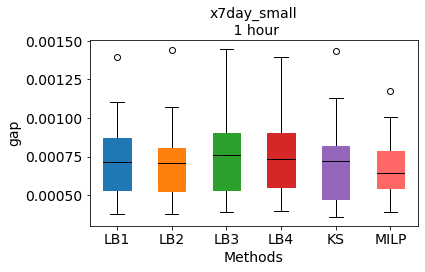

In [42]:
labels      = ['LB1','LB2','LB3','LB4','KS','MILP']
x           = [lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h,milp_1h]
medianprops = dict(color='black') #https://matplotlib.org/stable/gallery/statistics/boxplot.html
fig,ax  = plt.subplots()
#ax.set_title('gap\n('+filter+')')
bp = ax.boxplot(x,           
positions=[1,2,3,4,5,6],              # where to put these arrays
labels = labels, patch_artist=True ,medianprops=medianprops)  # allow filling the box with colors
## Relative gap in one hour
ax.set_title(filter+'\n 1 hour', fontsize=fontsize)
ax.set_xlabel('Methods'  , fontsize=fontsize)
ax.set_ylabel('gap'      , fontsize=fontsize)
for i in range(len(x)):
  bp['boxes'][i].set_facecolor('black')
  bp['boxes'][i].set_color(str(palette[i]))

fig.tight_layout()
namefile = dir+'fig:boxplotgap_1h'+'_'+filter+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

In [16]:
## https://www.geeksforgeeks.org/data-visualization-with-python-seaborn/
method1 = ['MILP' ]*(len(milp_1h))
method2 = ['LB1'   ]*(len(lbc1_1h))
method3 = ['LB2'   ]*(len(lbc2_1h))
method4 = ['LB3'   ]*(len(lbc3_1h))
method5 = ['LB4'   ]*(len(lbc4_1h))
method6 = ['KS'    ]*(len(ks_1h))
method  = method1 + method2 + method3 + method4 + method5 + method6
data    = np.concatenate((milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h), axis=0)
# initialise data of lists.
data = {'gap'       :data,
        'method'  :method}  
df1 = pd.DataFrame( data )
#fig, ax = plt.subplots(figsize=(8, 6))
#sns.histplot(df1, x="gap", hue="method", element="step") #,bins=15

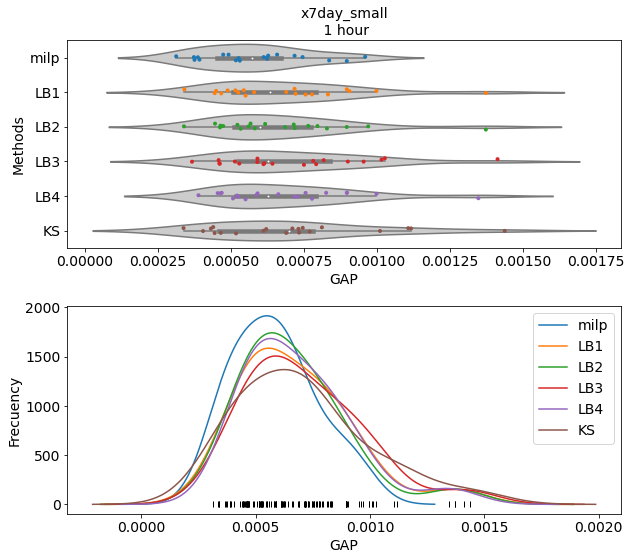

In [38]:
if True:
  import seaborn as sns
  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9, 8))
  sns.violinplot(
      x       = df1.gap,
      y       = df1.method,
      color   = '.8',
      ax      = axs[0]  )
  sns.stripplot(
      x       = df1.gap,
      y       = df1.method,
      data    = df1,
      size    = 4,
      jitter  = 0.1,
      ax      = axs[0]  )
  #axs[0].set_title('Distribution of methods')
  axs[0].set_ylabel('methods')
  axs[0].set_title(filter+'\n 1 hour', fontsize=fontsize)
  axs[0].set_xlabel('GAP'                                 , fontsize=fontsize)
  axs[0].set_ylabel('Methods'                             , fontsize=fontsize)
  fig.tight_layout()

  for i in df1.method.unique():
      datos_temp = df1[df1.method == i]['gap']
      datos_temp.plot.kde(ax=axs[1], label=i)
      axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

  axs[1].legend()
  axs[1].set_xlabel('GAP'       , fontsize=fontsize)
  axs[1].set_ylabel('Frecuency' , fontsize=fontsize)
  fig.tight_layout()
  namefile = dir+'fig:violinAll_1h'+'_'+filter+'.pdf'
  plt.savefig(namefile, transparent=True)
  plt.show()

## Carga de resultados de stat


20 0 2


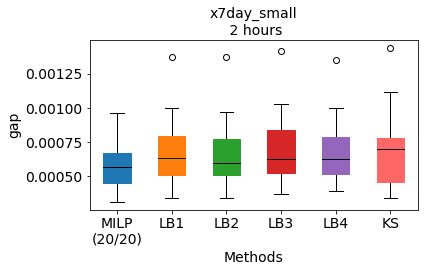

In [45]:
##Imprimir GAP
#milp2   = pd.to_numeric(df.g_milp2 ).to_numpy()
milp    = pd.to_numeric(df.g_milp  ).to_numpy()
harjk   = pd.to_numeric(df.g_harjk ).to_numpy()
harduc  = pd.to_numeric(df.g_harduc).to_numpy()
lbc1    = pd.to_numeric(df.g_lbc1  ).to_numpy()
lbc2    = pd.to_numeric(df.g_lbc2  ).to_numpy()
lbc3    = pd.to_numeric(df.g_lbc3  ).to_numpy()
lbc4    = pd.to_numeric(df.g_lbc4  ).to_numpy()
ks      = pd.to_numeric(df.g_ks    ).to_numpy()

## Contamos las soluciones no encontradas
n          = len(harduc)                ## Total de instancias
n_milp_ns  = len(milp[np.isnan(milp)])
n_harjk_ns = len(harjk[np.isnan(harjk)])
print(n,n_milp_ns,n_harjk_ns)

df = df[df['g_milp'].notna()]
milp    = pd.to_numeric(df.g_milp  ).to_numpy()
harjk   = pd.to_numeric(df.g_harjk ).to_numpy()
harduc  = pd.to_numeric(df.g_harduc).to_numpy()
lbc1    = pd.to_numeric(df.g_lbc1  ).to_numpy()
lbc2    = pd.to_numeric(df.g_lbc2  ).to_numpy()
lbc3    = pd.to_numeric(df.g_lbc3  ).to_numpy()
lbc4    = pd.to_numeric(df.g_lbc4  ).to_numpy()
ks      = pd.to_numeric(df.g_ks    ).to_numpy()
#milp    = milp[~np.isnan(milp)]                 ## limpiamos NaN
harjk  = harjk[~np.isnan(harjk)]                 ## limpiamos NaN

labels      = ['MILP\n('+str(n-n_milp_ns)+'/'+str(n)+')','LB1','LB2','LB3','LB4','KS'] ##'MILP2',
medianprops = dict(color='black') #https://matplotlib.org/stable/gallery/statistics/boxplot.html
x           = [milp,lbc1,lbc2,lbc3,lbc4,ks]
fig,ax      = plt.subplots()
#ax.set_title('gap\n('+filter+')')
bp = ax.boxplot(x,           
positions=[1,2,3,4,5,6],              # where to put these arrays
labels = labels, patch_artist=True, medianprops=medianprops )  # allow filling the box with colors
## Relative gap in two hour
ax.set_title(filter+'\n 2 hours', fontsize=fontsize)
ax.set_xlabel('Methods'  , fontsize=fontsize)
ax.set_ylabel('gap'      , fontsize=fontsize)
for i in range(len(x)):
  bp['boxes'][i].set_facecolor('black')
  bp['boxes'][i].set_color(str(palette[i]))
fig.tight_layout()
namefile = dir+'fig:boxplotgap'+'_'+filter+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

## Análisis estadístico descriptivo

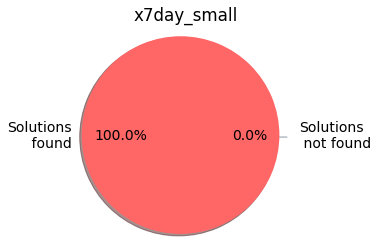

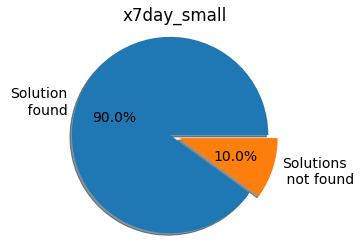

In [19]:
def pie(title='Apple pie',labels=['Apple','Cinammon'],sizes=[7,3],colors=['#1f77b4', '#ff7f0e','#66b3ff','#ff6666','#99ff99',]):
  explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
  fig1, ax1 = plt.subplots()
  mpl.rcParams['font.size'] = fontsize
  ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
          shadow=True, colors=colors, startangle=0)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  ax1.set_title(title)

  fig.tight_layout()
  plt.show()

## 'Solutions obtained by the Solver'
pie(title=''+filter+'',labels=['Solutions\n found','Solutions\n not found', ],sizes=[n-n_milp_ns, n_milp_ns ],colors=['#ff6666','#66b3ff','#99ff99',])
## 'Solutions obtained by the Harjunkosky constructive'
pie(title=''+filter+'',labels=['Solution\n found','Solutions\n not found', ],sizes=[n-n_harjk_ns,n_harjk_ns])

In [20]:
## https://www.geeksforgeeks.org/data-visualization-with-python-seaborn/
method  = ['Harjk' ]*(len(harjk))
method2 = ['Harduc']*(len(harduc))
method  = method + method2
data    = np.concatenate((harjk, harduc), axis=0)
# initialise data of lists.
data = {'gap' :data, 'method' :method}  
df1 = pd.DataFrame( data )

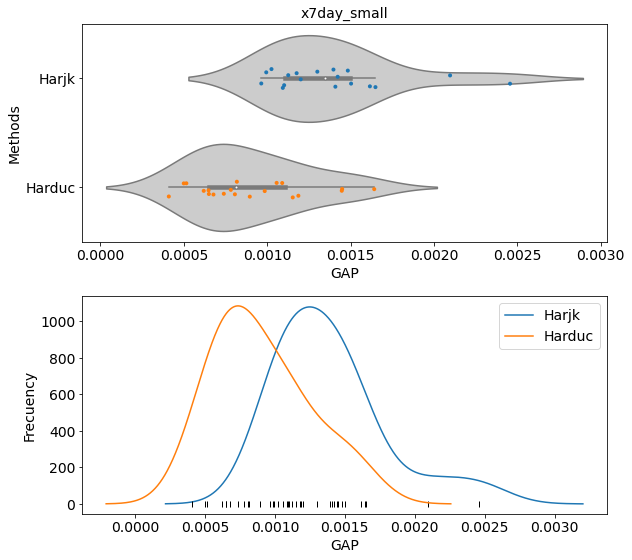

In [21]:
if True:
  import seaborn as sns
  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9, 8))
  sns.violinplot(
      x       = df1.gap,
      y       = df1.method,
      color   = '.8',
      ax      = axs[0]  )
  sns.stripplot(
      x       = df1.gap,
      y       = df1.method,
      data    = df1,
      size    = 4,
      jitter  = 0.1,
      ax      = axs[0] )
  #axs[0].set_title('Distribución de gap por método')
  axs[0].set_ylabel('methods')
  ##Distribution of methods
  axs[0].set_title(''+filter+'', fontsize=fontsize)
  axs[0].set_xlabel('GAP'      , fontsize=fontsize)
  axs[0].set_ylabel('Methods'  , fontsize=fontsize)
  fig.tight_layout()

  for i in df1.method.unique():
      datos_temp = df1[df1.method == i]['gap']
      datos_temp.plot.kde(ax=axs[1], label=i)
      axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

  # axs[1].set_xlabel('gap')
  axs[1].legend()
  axs[1].set_xlabel('GAP'       , fontsize=fontsize)
  axs[1].set_ylabel('Frecuency' , fontsize=fontsize)
  fig.tight_layout()

  namefile = dir+'fig:violinHarduc'+'_'+filter+'.pdf'
  plt.savefig(namefile, transparent=True)
  plt.show()

In [22]:
## https://www.geeksforgeeks.org/data-visualization-with-python-seaborn/
method1 = ['milp' ]*(len(milp))
method2 = ['LB1'   ]*(len(lbc1))
method3 = ['LB2'   ]*(len(lbc2))
method4 = ['LB3'   ]*(len(lbc3))
method5 = ['LB4'   ]*(len(lbc4))
method6 = ['KS'    ]*(len(ks))
method  = method1 + method2 + method3 + method4 + method5 + method6
data    = np.concatenate((milp,lbc1,lbc2,lbc3,lbc4,ks), axis=0)
# initialise data of lists.
data = {'gap'       :data,
        'method'  :method}  
df1 = pd.DataFrame( data )
#fig, ax = plt.subplots(figsize=(8, 6))
#sns.histplot(df1, x="gap", hue="method", element="step") #,bins=15

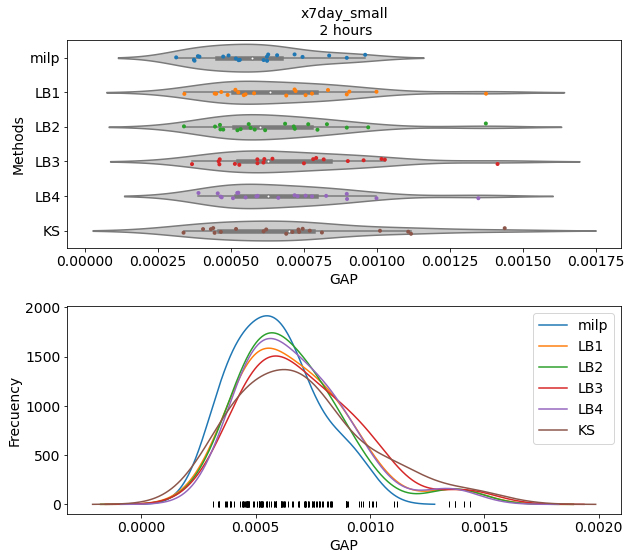

In [44]:
if True:
  import seaborn as sns
  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9, 8))
  sns.violinplot(
      x       = df1.gap,
      y       = df1.method,
      color   = '.8',
      ax      = axs[0]  )
  sns.stripplot(
      x       = df1.gap,
      y       = df1.method,
      data    = df1,
      size    = 4,
      jitter  = 0.1,
      ax      = axs[0]  )
  axs[0].set_ylabel('methods')
  ## Distribution of methods
  axs[0].set_title(filter+'\n 2 hours', fontsize=fontsize)
  axs[0].set_xlabel('GAP'                                 , fontsize=fontsize)
  axs[0].set_ylabel('Methods'                             , fontsize=fontsize)
  fig.tight_layout()

  for i in df1.method.unique():
      datos_temp = df1[df1.method == i]['gap']
      datos_temp.plot.kde(ax=axs[1], label=i)
      axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

  axs[1].legend()
  axs[1].set_xlabel('GAP'       , fontsize=fontsize)
  axs[1].set_ylabel('Frecuency' , fontsize=fontsize)
  fig.tight_layout()

  namefile = dir+'fig:violinAll'+'_'+filter+'.pdf'
  plt.savefig(namefile, transparent=True)
  plt.show()

## Almacenamos a archivos zip

In [24]:
!zip -r file.zip '/content/Figures'

  adding: content/Figures/ (stored 0%)
  adding: content/Figures/fig:violinAll_1h_x7day_small.pdf (deflated 17%)
  adding: content/Figures/fig:boxplotgap_x7day_small.pdf (deflated 29%)
  adding: content/Figures/fig:uc_069_x7day_small.pdf (deflated 32%)
  adding: content/Figures/fig:uc_102_x7day_small.pdf (deflated 32%)
  adding: content/Figures/fig:uc_106_x7day_small.pdf (deflated 31%)
  adding: content/Figures/fig:uc_105_x7day_small.pdf (deflated 31%)
  adding: content/Figures/fig:uc_103_x7day_small.pdf (deflated 32%)
  adding: content/Figures/fig:violinHarduc_x7day_small.pdf (deflated 22%)
  adding: content/Figures/fig:uc_068_x7day_small.pdf (deflated 32%)
  adding: content/Figures/fig:uc_108_x7day_small.pdf (deflated 32%)
  adding: content/Figures/fig:uc_066_x7day_small.pdf (deflated 32%)
  adding: content/Figures/fig:uc_061_x7day_small.pdf (deflated 33%)
  adding: content/Figures/fig:uc_101_x7day_small.pdf (deflated 32%)
  adding: content/Figures/fig:uc_109_x7day_small.pdf (deflate

## Functions

In [25]:
def means_test(alternative,labels,samples,alpha=0.05):
## Ho(Accepted): The difference between the pairs follows a symmetric distribution around zero.
## Ha(Rejected): The difference between the pairs does not follow a symmetric distribution around zero.
## We conduct the Mann-whitney U or two-sample t test alternative= {'two-sided', 'greater', 'less'} 
# ==============================================================================
  ## Tipo de prueba

    Ho   = labels[0]+'-'+labels[1]+': means the samples is of the same distribution.'
    decision1   = 'We fail to reject the Ho; Ho accepted:'
    if alternative == 'less':
      message1='\t: We fail to reject the null hypothesis; Ho accepted: \n\tThe difference between the pairs follows a symmetric distribution around zero.'
      message2='\t: *We reject the null hypothesis and accept alternative hypothesis Ha:\n\t'+labels[0]+'\'s mean is less than '+labels[1]+'\'s mean.'
      Ho   = labels[0]+'-'+labels[1]+': The means difference of the samples from the same distribution.'
      decision2   = 'We reject the Ho and accept Ha: '+labels[0]+'\'s mean is less than '+labels[1]+'\'s mean.'
    if alternative == 'greater':
      message2='\t: *We reject the null hypothesis and accept alternative hypothesis Ha:\n\t'+labels[0]+'\'s mean is greater than '+labels[1]+'\'s mean.'
      Ho   = labels[0]+'-'+labels[1]+': The means difference of the samples from the same distribution.'
      decision2   = 'We reject the Ho and accept Ha: '+labels[0]+'\'s mean is greater than '+labels[1]+'\'s mean.'
    if alternative == 'two-sided':
      message2='\t: *We reject the null hypothesis and accept alternative hypothesis Ha:\n\t The mean difference between the pairs not follows a symmetric distribution around zero.'
      Ho   = labels[0]+'-'+labels[1]+': The means difference of the samples from the same distribution.'
      decision2   = 'We reject the Ho and accept Ha: The means difference of the samples not from the same distribution.'

    ## Checamos normalidad 
    normal=[]
    i = 0
    for s in samples:
      if shapiro(s).pvalue > alpha:
        normal.append(True)
      else:
        # print(labels[i],'\t:',round(shapiro(s).statistic,4),'\t',round(shapiro(s).pvalue,4),'\tWe reject the null hypothesis and accept Ha: Sample is not from the normal distributions.')
        normal.append(False)
      i = i + 1

    ## Checamos homocedasticidad
    levene_test = stats.levene(samples[0], samples[1], center='mean')
    equalvar=False
    if levene_test.pvalue > alpha:
        equalvar =True
    #   print('[Harjk,Harduc]\t:',round(levene_test.statistic,4),round(levene_test.pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)')
    # else:
    #   print(labels[0],labels[1],'\t:',round(levene_test.statistic,4),round(levene_test.pvalue,4),'\tWe reject the Ho and accept Ha: the variances are not equal across all samples. (Po<=0.05)')
    test = ''
    if normal[0]==True and normal[1]==True and equalvar==True: ## T-test two samples
      test = 'T-test for two samples'
      # print(labels[0],labels[1],stats.ttest_ind(samples[0], samples[1], alternative=alternative) )
      if stats.ttest_ind(samples[0], samples[1], alternative=alternative).pvalue > alpha:
          # print('\t',message1)
          print(Ho,',',test,',', round(stats.ttest_ind(samples[0], samples[1], alternative=alternative).pvalue,4),',',decision1)
      else:
          # print('\t',message2)
          print(Ho,',',test,',', round(stats.ttest_ind(samples[0], samples[1], alternative=alternative).pvalue,4),',',decision2)
    else: ## Mann-whitney U Test
      test = 'Mann-whitney U'
      # print(labels[0],labels[1],stats.mannwhitneyu(samples[0], samples[1], alternative=alternative) )
      if stats.mannwhitneyu(samples[0], samples[1], alternative=alternative).pvalue > alpha:
          # print('\t',message1)
          print(Ho,',',test,',', round(stats.mannwhitneyu(samples[0], samples[1], alternative=alternative).pvalue,4),',',decision1)
      else:
          # print('\t',message2)
          print(Ho,',',test,',', round(stats.mannwhitneyu(samples[0], samples[1], alternative=alternative).pvalue,4),',',decision2)
## Kruskal-Wallis test discussion:  In this example, the test statistic comes out to be equal to 87 and the corresponding p-value is 2.1856E-17. 
## (As the p-value is not less than 0.05, we cannot reject the null hypothesis that the median of optimality gap is the same for all groups. 
## Hence, We don’t have sufficient proof to claim that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)
## (As the p-value is less than 0.05, we reject the null hypothesis that the median of optimality gap is the same for all groups. 
## Hence, We don’t have sufficient proof to reject that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)

## Pruebas de Normalidad de todos los métodos

In [26]:
# conduct the  Shapiro-Wilk Test
## https://www.geeksforgeeks.org/how-to-perform-a-shapiro-wilk-test-in-python/
## This is a hypotheses test and the two hypotheses are as follows:
## Ho(Accepted): Sample is from the normal distributions.(Po>0.05)
## Ha(Rejected): Sample is not from the normal distributions.
## Example 1: Shapiro-Wilk test on the normally distributed sample in Python
## In this example, we will be simply using the shapiro() function from 
## the scipy.stats library to Conduct a Shapiro-Wilk test on the randomly generated data with 500 data points in python. 

samples = (harjk,harduc,milp,lbc1,lbc2,lbc3,lbc4,ks,milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h)
labels  = ['Harjk','Harduc','MILP','LB1','LB2','LB3','LB4','KS','MILP','LB1','LB2','LB3','LB4','KS']
normal  = []
i       = 0
test    = 'Shapiro-Wilk'
print('Normality hypothesis test summary ('+filter+')')
print('Null hypothesis,Test,Significance,Decision')
for s in (samples):
  Ho = labels[i]+' '+ 'is from the normal distributions.'
  # print(labels[i],':', shapiro(s).statistic, shapiro(s).pvalue)
  if shapiro(s).pvalue > 0.05:
    decision='We fail to reject the Ho; Ho accepted: samples is from the normal distributions.'
    print(labels[i]+' is from the normal distribution,',test,',', round(shapiro(s).pvalue,4),',',decision)
    # print(labels[i],'\t:',round(shapiro(s).statistic,4),'\t',round(shapiro(s).pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: \n\tSample is from the normal distributions.(Po>0.05)')
    normal.append(True)
  else:
    decision='We reject the null hypothesis Ho and accept Ha: samples is not from the normal distributions.'
    print(labels[i]+' is from the normal distribution,',test,',', round(shapiro(s).pvalue,4),',',decision)
    # print(labels[i],'\t:',round(shapiro(s).statistic,4),'\t',round(shapiro(s).pvalue,4),'\tWe reject the null hypothesis and accept alternative hypothesis Ha: \n\tSample is not from the normal distributions.')
    normal.append(False)
  i = i + 1

print('*  Significance level 0.05')
print('** Significance level 0.01')
## Output Interpretation:
## Returns: (statistic: The test statistic, p-value: The p-value for the hypothesis test)
## a)Since in the above example, the p-value is 0.73 which is more than the threshold(0.05) which is the alpha(0.05) then we fail to reject the null hypothesis 
##   i.e. we do (not have sufficient evidence) to say that sample does not come from a normal distribution.
## b)Since in the above example, the p-value is 0.0001 which is less than the alpha(0.05) then we reject the null hypothesis 
##   i.e. we (have sufficient evidence) to say that sample does not come from a normal distribution.

Normality hypothesis test summary (x7day_small)
Null hypothesis,Test,Significance,Decision
Harjk is from the normal distribution, Shapiro-Wilk , 0.0137 , We reject the null hypothesis Ho and accept Ha: samples is not from the normal distributions.
Harduc is from the normal distribution, Shapiro-Wilk , 0.3069 , We fail to reject the Ho; Ho accepted: samples is from the normal distributions.
MILP is from the normal distribution, Shapiro-Wilk , 0.4482 , We fail to reject the Ho; Ho accepted: samples is from the normal distributions.
LB1 is from the normal distribution, Shapiro-Wilk , 0.0614 , We fail to reject the Ho; Ho accepted: samples is from the normal distributions.
LB2 is from the normal distribution, Shapiro-Wilk , 0.0307 , We reject the null hypothesis Ho and accept Ha: samples is not from the normal distributions.
LB3 is from the normal distribution, Shapiro-Wilk , 0.0997 , We fail to reject the Ho; Ho accepted: samples is from the normal distributions.
LB4 is from the normal di

## Estadistica inferencial para los métodos contructivos

### Pruebas de Homocedasticidad entre los resultados de Harduc y Harjk

In [27]:
## homocedasticidad.
## https://www.cienciadedatos.net/documentos/pystats07-test-homocedasticidad-heterocedasticidad-python.html
## https://stats.stackexchange.com/questions/135232/bartletts-test-vs-levenes-test
## We conducting Levene’s Test or Bartlett’s Test of homogeneity of variance we are dealing with two hypotheses. These two are simply put:
## Ho(Accepted): the variances are equal across all samples
## Ha(Rejected): the variances are not equal across all samples

test    = 'Levene'
print('Homoscedasticity hypothesis test summary ('+filter+')')
print('Null hypothesis,Test,Significance,Decision')
Ho = 'Harduc and Harjk'+': the variances are equal.'

# Levene test
# ==============================================================================
levene_test = stats.levene(harjk, harduc, center='mean')
# print(levene_test)
equalvar=False
if levene_test.pvalue > 0.05:
    decision='We fail to reject the Ho; Ho accepted.'
    print('Harjk,Harduc'+' the variances are equal across all samples,',test,',', round(levene_test.pvalue,4),',',decision)
    # print('[Harjk,Harduc]\t:',round(levene_test.statistic,4),round(levene_test.pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)')
    equalvar=True
else:
    decision='We reject the Ho and accept Ha: the variances are not equal.'
    print('Harjk,Harduc'+' the variances are equal across all samples,',test,',', round(levene_test.pvalue,4),',',decision)
    # print('[Harjk,Harduc]\t:',round(levene_test.statistic,4),round(levene_test.pvalue,4),'\tWe reject the null hypothesis and accept Ha: the variances are not equal across all samples. (Po<=0.05)')
print('*  Significance level 0.05')
print('** Significance level 0.01')
print('\n')


# Fligner-Killeen
# ==============================================================================
fligner_test = stats.fligner(harjk, harduc, center='mean')
print(fligner_test)
if fligner_test.pvalue > 0.05:
    print('[Harjk,Harduc]\t:',round(fligner_test.statistic,4),round(fligner_test.pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)')
else:
    print('[Harjk,Harduc]\t:',round(fligner_test.statistic,4),round(fligner_test.pvalue,4),'\tWe reject the null hypothesis and accept Ha: the variances are not equal across all samples. (Po<=0.05)')

## Output Interpretation:
## a) This means, for example, that if we get a p-value larger than 0.05 we can assume 
## hat our data is heteroscedastic and we can continue carrying out a parametric test 
## such as the two-sample t-test. 
## b) If we, on the other hand, get a statistically 
## significant result we may want to carry out the Mann-Whitney U test. 
## Ninguno de los test muestra evidencias para rechazar la hipótesis de que los 
## dos grupos tienen la misma varianza, homocedasticidad. p-value >>>> 0.05

Homoscedasticity hypothesis test summary (x7day_small)
Null hypothesis,Test,Significance,Decision
Harjk,Harduc the variances are equal across all samples, Levene , 0.9742 , We fail to reject the Ho; Ho accepted.
*  Significance level 0.05
** Significance level 0.01


FlignerResult(statistic=0.005202024410978706, pvalue=0.9425023824391021)
[Harjk,Harduc]	: 0.0052 0.9425 	We fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)


## Test of differences between Harduc and Harjk means  


In [28]:
samples = (harduc,harjk)
print('differences means test summary between Harduc and Harjk ('+filter+')')
print('Null hypothesis,Test,Significance,Decision')

labels = ['Harduc','Harjk']
means_test('less',labels,samples,alpha=0.05)

print('*  Significance level 0.05')
print('** Significance level 0.01')
print('\n')

## Output Interpretation:
## In the above example, the p-value is 0.2 which is less than the threshold(0.05) which is the alpha(0.05) 
## i.e. p-value<alpha which means the sample is of the same distribution 
## and the sample distributions are equal if in the case if the p-value>0.05 than it would be opposite.

differences means test summary between Harduc and Harjk (x7day_small)
Null hypothesis,Test,Significance,Decision
Harduc-Harjk: The means difference of the samples from the same distribution. , Mann-whitney U , 0.0002 , We reject the Ho and accept Ha: Harduc's mean is less than Harjk's mean.
*  Significance level 0.05
** Significance level 0.01




## Analysis of variance between all methods using ANOVA or Kruskal-wallis
**2 HORAS**

https://www.geeksforgeeks.org/how-to-perform-a-kruskal-wallis-test-in-python/

In [29]:
## Ho(Accepted): The mean for each population is equal.
## Ha(Rejected): At least one population mean is different from the rest.
## We conduct the ANOVA or Kruskal-wallis test
# ==============================================================================
labels = ['MILP','LB1','LB2','LB3','LB4','KS']

print('Analysis of variance summary ('+filter+')'+'(2 hours)')
print('Null hypothesis,Test,Significance,Decision')
Ho = 'MILP LB1 LB2 LB3 LB4 KS'+': The mean for each population is equal.'

if normal[2]==True and normal[3]==True and normal[4]==True and normal[5]==True and normal[6]==True and normal[7]==True:
  test='ANOVA one way'
  #print(stats.f_oneway(milp,lbc1,lbc2,lbc3,lbc4,ks))
  if stats.f_oneway(milp,lbc1,lbc2,lbc3,lbc4,ks).pvalue > 0.05:
      decision='We fail to reject the Ho; Ho accepted.'
      print(Ho,test,',', round(stats.f_oneway(milp,lbc1,lbc2,lbc3,lbc4,ks).pvalue,4),',',decision)
      # print('[All heuristics]:','\tWe fail to reject the null hypothesis; Ho accepted:\n\tThe mean for each population is equal.')
  else:
      decision='We reject the Ho and accept Ha: at least one population mean is different from the rest.'
      print(Ho,test,',', round(stats.f_oneway(milp,lbc1,lbc2,lbc3,lbc4,ks).pvalue,4),',',decision)
      # print('[All heuristics]:','\tWe reject the null hypothesis and accept alternative hypothesis Ha:\n\tAt least one population mean is different from the rest.')
else:
  test='Kruskal-wallis test'
  #print(stats.kruskal(milp,lbc1,lbc2,lbc3,lbc4,ks))
  if stats.kruskal(milp,lbc1,lbc2,lbc3,lbc4,ks).pvalue > 0.05:
      decision='We fail to reject the Ho; Ho accepted.'
      print(Ho,test,',', round(stats.kruskal(milp,lbc1,lbc2,lbc3,lbc4,ks).pvalue,4),',',decision)
      # print('[All heuristics]:','\tWe fail to reject the null hypothesis; Ho accepted:\n\tThe mean for each population is equal.')
  else:
      decision='We reject the Ho and accept Ha: at least one population mean is different from the rest.'
      print(Ho,test,',', round(stats.kruskal(milp,lbc1,lbc2,lbc3,lbc4,ks).pvalue,4),',',decision)
print('*  Significance level 0.05')
print('** Significance level 0.01')
print('\n')
## Output Interpretation:
## Null Hypothesis: There is no significant difference between the given conditions of measurement OR the probability 
## distributions for all the conditions are the same. (Medians are same)
## In this example, the test statistic is 13.3514 and the corresponding p-value is p = 0.00126. 
## Since this p-value is less than 0.05, we can reject the null hypothesis that the mean response time is the same for all three drugs.
## In other words, we have sufficient evidence to conclude that the type of drug used leads to statistically significant differences in response time.

Analysis of variance summary (x7day_small)(2 hours)
Null hypothesis,Test,Significance,Decision
MILP LB1 LB2 LB3 LB4 KS: The mean for each population is equal. Kruskal-wallis test , 0.6995 , We fail to reject the Ho; Ho accepted.
*  Significance level 0.05
** Significance level 0.01




**1 HORAS** (ANàlisis de varianza)


https://www.geeksforgeeks.org/how-to-perform-a-kruskal-wallis-test-in-python/

In [30]:
## 1 HORA
##labels = ['milp_1h','LB1','LB2','LB3','LB4','ks_1h']

print('Analysis of variance summary ('+filter+')'+'(2 hours)')
print('Null hypothesis,Test,Significance,Decision')
Ho = 'milp_1h LB1 LB2 LB3 LB4 ks_1h'+': The mean for each population is equal.'

if normal[2]==True and normal[3]==True and normal[4]==True and normal[5]==True and normal[6]==True and normal[7]==True:
  test='ANOVA one way'
  #print(stats.f_oneway(milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h))
  if stats.f_oneway(milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h).pvalue > 0.05:
      decision='We fail to reject the Ho; Ho accepted.'
      print(Ho,test,',', round(stats.f_oneway(milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h).pvalue,4),',',decision)
      # print('[All heuristics]:','\tWe fail to reject the null hypothesis; Ho accepted:\n\tThe mean for each population is equal.')
  else:
      decision='We reject the Ho and accept Ha: at least one population mean is different from the rest.'
      print(Ho,test,',', round(stats.f_oneway(milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h).pvalue,4),',',decision)
      # print('[All heuristics]:','\tWe reject the null hypothesis and accept alternative hypothesis Ha:\n\tAt least one population mean is different from the rest.')
else:
  test='Kruskal-wallis test'
  #print(stats.kruskal(milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h))
  if stats.kruskal(milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h).pvalue > 0.05:
      decision='We fail to reject the Ho; Ho accepted.'
      print(Ho,test,',', round(stats.kruskal(milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h).pvalue,4),',',decision)
      # print('[All heuristics]:','\tWe fail to reject the null hypothesis; Ho accepted:\n\tThe mean for each population is equal.')
  else:
      decision='We reject the Ho and accept Ha: at least one population mean is different from the rest.'
      print(Ho,test,',', round(stats.kruskal(milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h).pvalue,4),',',decision)
print('*  Significance level 0.05')
print('** Significance level 0.01')
print('\n')
## Output Interpretation:
## Null Hypothesis: There is no significant difference between the given conditions of measurement OR the probability 
## distributions for all the conditions are the same. (Medians are same)
## In this example, the test statistic is 13.3514 and the corresponding p-value is p = 0.00126. 
## Since this p-value is less than 0.05, we can reject the null hypothesis that the mean response time is the same for all three drugs.
## In other words, we have sufficient evidence to conclude that the type of drug used leads to statistically significant differences in response time.

Analysis of variance summary (x7day_small)(2 hours)
Null hypothesis,Test,Significance,Decision
milp_1h LB1 LB2 LB3 LB4 ks_1h: The mean for each population is equal. Kruskal-wallis test , 0.9441 , We fail to reject the Ho; Ho accepted.
*  Significance level 0.05
** Significance level 0.01




## Post-Hoc analysis

In [31]:
## TWO HOURS
## We applying the Post Hoc analysis with Mann-whitney U Test to know which pairs have a significant difference between them.
## The Mann–Whitney U test is applied to independent samples.
# ==============================================================================
## We conduct the Mann-whitney U {“two-sided”, “greater”, “less”}, optional
# ==============================================================================
samples= [ milp,lbc1,lbc2,lbc3,lbc4,ks ]
labels = ['MILP','LB1','LB2','LB3','LB4','KS']
means  = []
print('\n RANKING (2 HOUR)==============================================================================\n')
i = 0
ordered_labels  = []
ordered_samples = []
for s in samples:
  means.append((i,np.mean(s)))
  i = i + 1
means.sort(key=lambda tup: tup[1], reverse=False) ##reverse=False
i = 0
for m in means:  
  ordered_samples.append(samples[m[0]])
  ordered_labels.append(labels[m[0]])
  i = i + 1
  print(labels[m[0]],m[1])
print('\n Ha:less,alpha=0.05 (2 HOUR)======================================================================\n')
print('Means difference hypothesis test summary ('+filter+')')
print('Null hypothesis,Test,Significance,Decision')
for i in range(len(ordered_labels)):
  for j in range(len(ordered_labels)):
    if j > i:
      means_test('less',(ordered_labels[i],ordered_labels[j]),(ordered_samples[i],ordered_samples[j]),alpha=0.05)
print('\n Ha:less,alpha=0.01 (2 HOUR)=======================================================================\n')
for i in range(len(ordered_labels)):
  for j in range(len(ordered_labels)):
    if j > i:
      means_test('less',(ordered_labels[i],ordered_labels[j]),(ordered_samples[i],ordered_samples[j]),alpha=0.01)


 RANKING (2 HOUR)==============================================================================

MILP 0.00058377745
LB2 0.0006655600000000002
LB1 0.0006783949999999999
LB4 0.00068312
KS 0.00070658
LB3 0.000714245

 Ha:less,alpha=0.05 (2 HOUR)======================================================================

Means difference hypothesis test summary (x7day_small)
Null hypothesis,Test,Significance,Decision
MILP-LB2: The means difference of the samples from the same distribution. , Mann-whitney U , 0.1651 , We fail to reject the Ho; Ho accepted:
MILP-LB1: The means difference of the samples from the same distribution. , T-test for two samples , 0.0857 , We fail to reject the Ho; Ho accepted:
MILP-LB4: The means difference of the samples from the same distribution. , Mann-whitney U , 0.1042 , We fail to reject the Ho; Ho accepted:
MILP-KS: The means difference of the samples from the same distribution. , T-test for two samples , 0.0555 , We fail to reject the Ho; Ho accepted:
MILP-LB3

In [32]:
## ONE HOURS
## We applying the Post Hoc analysis with Mann-whitney U Test to know which pairs have a significant difference between them.
## The Mann–Whitney U test is applied to independent samples.
# ==============================================================================
## We conduct the Mann-whitney U {“two-sided”, “greater”, “less”}, optional
# ==============================================================================
samples= [ milp_1h,lbc1_1h,lbc2_1h,lbc3_1h,lbc4_1h,ks_1h ]
labels = ['MILP','LB1','LB2','LB3','LB4','KS']
means  = []
print('\n RANKING (1 HOUR)==============================================================================\n')
i = 0
ordered_labels  = []
ordered_samples = []
for s in samples:
  means.append((i,np.mean(s)))
  i = i + 1
means.sort(key=lambda tup: tup[1], reverse=False) ##reverse=False
i = 0
for m in means:  
  ordered_samples.append(samples[m[0]])
  ordered_labels.append(labels[m[0]])
  i = i + 1
  print(labels[m[0]],m[1])
print('\n Ha:less,alpha=0.05 (1 HOUR)=====================================================================\n')
print('Means difference hypothesis test summary ('+filter+')')
print('Null hypothesis,Test,Significance,Decision')
for i in range(len(ordered_labels)):
  for j in range(len(ordered_labels)):
    if j > i:
      means_test('less',(ordered_labels[i],ordered_labels[j]),(ordered_samples[i],ordered_samples[j]),alpha=0.05)
print('\n Ha:less,alpha=0.01 (1 HOUR)=====================================================================\n')
for i in range(len(ordered_labels)):
  for j in range(len(ordered_labels)):
    if j > i:
      means_test('less',(ordered_labels[i],ordered_labels[j]),(ordered_samples[i],ordered_samples[j]),alpha=0.01)


 RANKING (1 HOUR)==============================================================================

MILP 0.0006773827603533147
LB2 0.0007140745390521895
KS 0.000723268405486239
LB1 0.000724931576249743
LB4 0.0007439673945486907
LB3 0.0007601092731656632

 Ha:less,alpha=0.05 (1 HOUR)=====================================================================

Means difference hypothesis test summary (x7day_small)
Null hypothesis,Test,Significance,Decision
MILP-LB2: The means difference of the samples from the same distribution. , Mann-whitney U , 0.3779 , We fail to reject the Ho; Ho accepted:
MILP-KS: The means difference of the samples from the same distribution. , T-test for two samples , 0.275 , We fail to reject the Ho; Ho accepted:
MILP-LB1: The means difference of the samples from the same distribution. , T-test for two samples , 0.252 , We fail to reject the Ho; Ho accepted:
MILP-LB4: The means difference of the samples from the same distribution. , T-test for two samples , 0.1759 , We f

## Descartes

In [33]:
# Conduct the Kruskal-Wallis Test
result = stats.kruskal(milp,lbc1,lbc2,lbc3,lbc4,ks)

# Print the result
print(result)
#Kruskal-Wallis test discussion:  In this example, the test statistic comes out to be equal to 87 and the corresponding p-value is 2.1856E-17. 
#(As the p-value is not less than 0.05, we cannot reject the null hypothesis that the median of optimality gap is the same for all groups. Hence, We don’t have sufficient proof to claim that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)
#(As the p-value is less than 0.05, we reject the null hypothesis that the median of optimality gap is the same for all groups. Hence, We don’t have sufficient proof to reject that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)

KruskalResult(statistic=3.0029151618279877, pvalue=0.6995363753726053)


In [34]:
## https://www.geeksforgeeks.org/data-visualization-with-python-seaborn/
if False:
  nor  = np.random.normal(size=100) 
  nor  = nor + 5
  ale  = np.random.uniform(size=100) 
  nor1 = np.random.normal(size=100) 
  nor1  = nor1 + 5
  ale1 = np.random.uniform(size=100)
  ale1  = ale1 + 5
  nor2 = np.random.normal(size=100)
  nor2  = nor2 + 5
  ale2 = np.random.uniform(size=100)  #'N','A','N1','A1','N2','A2',,nor,ale,nor1,ale1,nor2,ale2
  ale2  = ale2 + 5
  fig, ax = plt.subplots(figsize=(8, 6))
  method1 = ['nor' ]*(len(nor))
  method2 = ['ale' ]*(len(ale))
  method3 = ['nor1']*(len(nor1))
  method4 = ['ale1']*(len(ale1))
  method5 = ['nor2']*(len(nor2))
  method6 = ['ale2']*(len(ale2))
  method  = method1 + method2 + method3 + method4 + method5 + method6
  data    = np.concatenate((nor,ale,nor1,ale1,nor2,ale2), axis=0)
  # initialise data of lists.
  data = {'gap'       :data,
          'method'  :method}  
  df1 = pd.DataFrame( data )
  sns.histplot(df1, x="gap", hue="method", element="step") #,bins=15

  print('Mann-whitney U test NOR-ALE')
  if stats.mannwhitneyu(ale, nor, alternative='less').pvalue > 0.05:
      print('[ale,nor]\t:','We fail to reject the null hypothesis; Ho accepted: The median difference between the pairs follows a symmetric distribution around zero.')
  else:
      print('[ale,nor]\t:','We reject the null hypothesis and accept Ha: The median difference is positive α=0.05. Ale\'s mean is lower than Nor\'s mean.')

  print('kruskal-wallis test nor,ale1,nor1,ale2,nor2') ## ale,
  if stats.kruskal(ale,nor,nor1,nor2).pvalue > 0.05:
      print('[All heuristics]\t:','We fail to reject the null hypothesis; Ho accepted: The mean for each population is equal.')
  else:
      print('[All heuristics]\t:','We reject the null hypothesis and accept Ha: At least one population mean is different from the rest: α=0.05.')


### Wilcoxon test
https://www.geeksforgeeks.org/how-to-conduct-a-wilcoxon-signed-rank-test-in-python/

https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/

https://www.cienciadedatos.net/documentos/18_prueba_de_los_rangos_con_signo_de_wilcoxon

Comparaxion medias

https://www.cienciadedatos.net/documentos/pystats11-wilcoxon-mann-whitney-u-test-python

https://www.cienciadedatos.net/documentos/pystats10-t-test-python.html

https://www.cienciadedatos.net/documentos/pystats09-analisis-de-varianza-anova-python.html

https://www.cienciadedatos.net/documentos/15_inferencia_para_proporciones